<a href="https://colab.research.google.com/github/AmirJlr/Molecular-Property-Prediction/blob/master/Ml4Mol/12_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training GNN

We will use the same process discussed earlier. But, **for featurization we will use graphs and the model will be a message passing neural network**.

The process of training and validating model is below --

1. Clean up dataset
2. Featurize the data
3. Split the dataset
4. Create ``DataLoader`` for the dataset splits
5. Create the ML model, define loss function and optimizer
6. ``for`` loop for epochs
    1. ``for`` loop for training batches
        1. Do a forward pass
        2. Compute the loss
        3. Do backpropogation
    2. ``for`` loop for validation batches
        1. Do a forward pass
        2. Compute the loss
    

### Installing the packages

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00


In [ ]:
import torch_geometric

In [ ]:
# install dgl, rdkit and fast-ml
! pip install dgl
! pip install dgllife
! pip install rdkit
! pip install fast_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 855.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 1.2 MB/s eta 0:00:00
     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/731.7 MB 2.4 MB/s eta 0:04:37
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 974.4 kB/s eta 0:00:00


### Dataset operations

We will fetch the QM9 dataset and use HOMO-LUMO gap as the target for prediction.

In [ ]:
# import pandas library
import pandas as pd

# load the dataframe as CSV from URL.
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")

# create the dataset with smiles and gap
# we will use a 5% of the dataset to save time
dataset = df[["smiles","gap"]].sample(frac=0.05)

In [ ]:
dataset.shape

(6694, 2)

In [ ]:
dataset.head(5)

,smiles,gap
55844,C1C(CC1=O)OC(=O)N,0.2211
22346,CC1=CC(=NO)CN1C,0.1694
37725,C1C2C3C4OCC2N1C34,0.3082
70325,CC12CC1CC1CC21C,0.3182
89257,CC1CC2(O)C3OC3C12,0.3101


As we will use GNN, we need to convert the SMILES to graphs with atom and bond features. The dgl library has streamlined this process.

We will use the ``CanonicalAtomFeaturizer`` for atoms features and ``CanonicalBondFeaturizer`` for bonds. More details on the features can be found [here]()

In [ ]:
# import from rdkit and dgl-lifesci
from rdkit import Chem
from dgllife.utils import CanonicalAtomFeaturizer, CanonicalBondFeaturizer, \
mol_to_bigraph

# create the atom and bond featurizer object
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field="x")
bond_featurizer = CanonicalBondFeaturizer(bond_data_field="edge_attr")

Before applying the featurizers to entire dataset, let us look at generating a graph for ethane and applying the features

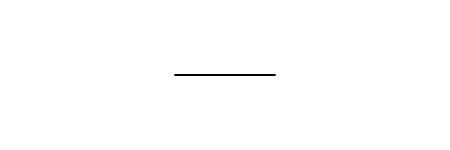

In [ ]:
smile = "CC"
mol = Chem.MolFromSmiles(smile)
mol

In [ ]:
type(mol)

rdkit.Chem.rdchem.Mol

In [ ]:
smiles = "CC"

# mol_to_graph requires the RDKit molecule and featurizers
mol = Chem.MolFromSmiles(smiles)
graph = mol_to_bigraph(mol, node_featurizer=atom_featurizer,
                     edge_featurizer=bond_featurizer)

# display the graph object
graph

Graph(num_nodes=2, num_edges=2,
      ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)})

In [ ]:
from torch_geometric.utils import from_dgl

In [ ]:
pyg_data = from_dgl(graph)

In [ ]:
pyg_data

Data(edge_index=[2, 2], x=[2, 74], edge_attr=[2, 12])

In [ ]:
graph.ndata["x"]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0.]])

In [ ]:
graph.edata["edge_attr"]

tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Atom features:
* One hot encoding of the atom type
* One hot encoding of the atom degree
* One hot encoding of the number of implicit Hs on the atom
* ...

More details in [documentation](https://lifesci.dgl.ai/api/utils.mols.html#featurization-for-molecules.)

We will create the graphs for all entries in the dataset.


In [ ]:
# helper functions to convert smiles to graph

def smiles2dgl_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    dgl_graph = mol_to_bigraph(mol, node_featurizer=atom_featurizer,
                     edge_featurizer=bond_featurizer)
    return dgl_graph


def smiles2pyg_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    dgl_graph = mol_to_bigraph(mol, node_featurizer=atom_featurizer,
                     edge_featurizer=bond_featurizer)
    pyg_graph = torch_geometric.utils.from_dgl(dgl_graph)
    return pyg_graph

In [ ]:
dataset["dgl_graph"] = dataset["smiles"].apply(smiles2dgl_graph)
dataset["pyg_graph"] = dataset["smiles"].apply(smiles2pyg_graph)

In [ ]:
dataset.head(3)

,smiles,gap,dgl_graph,pyg_graph
55844,C1C(CC1=O)OC(=O)N,0.2211,"Graph(num_nodes=9, num_edges=18,\n ndata_...","[(edge_index, [tensor([8, 4, 4, 7, 7, 0, 0, 2,..."
22346,CC1=CC(=NO)CN1C,0.1694,"Graph(num_nodes=9, num_edges=18,\n ndata_...","[(edge_index, [tensor([0, 8, 8, 5, 5, 2, 2, 6,..."
37725,C1C2C3C4OCC2N1C34,0.3082,"Graph(num_nodes=9, num_edges=24,\n ndata_...","[(edge_index, [tensor([5, 0, 0, 4, 4, 1, 1, 3,..."


Here, we use random splitting with Fast-ML. Other splitters could also be used.

In [ ]:
# import the function to split into train-valid-test
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, \
X_test, y_test = train_valid_test_split(dataset[["dgl_graph","gap"]],
                                        target = "gap",
                                        train_size=0.8,
                                        valid_size=0.1,
                                        test_size=0.1)

In [ ]:
sample_data = dataset['dgl_graph'].head(5)
sample_data

55844    Graph(num_nodes=9, num_edges=18,\n      ndata_...
22346    Graph(num_nodes=9, num_edges=18,\n      ndata_...
37725    Graph(num_nodes=9, num_edges=24,\n      ndata_...
70325    Graph(num_nodes=9, num_edges=22,\n      ndata_...
89257    Graph(num_nodes=9, num_edges=22,\n      ndata_...
Name: dgl_graph, dtype: object

In [ ]:
sample_y = dataset['gap'].head(5)
sample_y.shape

(5,)

### Looking a the dataset

In [ ]:
X_test.shape, y_test.shape

((670, 1), (670,))

### Dataloader

The ``DataLoader`` helps in creating batches, shuffling data and feeding the data into to model during training. The dataloader requires the dataset in the form (X,y) where X is the graph and y is the target.

The dataloader code below does this transformation. The ``collate_data`` function is need for batching the (X,y) entries before feeding the batches into the model.

In [ ]:
import dgl

def collate_data(data):
  # our data is in the form of list of (X,y)
  # the map function thus maps accordingly
  graphs, y = map(list, zip(*data))

  # for creating a batch of graph, we use the batch function
  batch_graph = dgl.batch(graphs)

  # we need to stack the ys for different entries in the batch
  y = torch.stack(y, dim=0)

  return batch_graph, y

In [ ]:
sample_data.values.tolist()

[Graph(num_nodes=9, num_edges=18,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 Graph(num_nodes=9, num_edges=18,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 Graph(num_nodes=9, num_edges=24,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 Graph(num_nodes=9, num_edges=22,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 Graph(num_nodes=9, num_edges=22,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)})]

In [ ]:
import torch

In [ ]:
torch.tensor(sample_y.tolist(), dtype=torch.float32)

tensor([0.2211, 0.1694, 0.3082, 0.3182, 0.3101])

In [ ]:
zip(sample_data.values.tolist(), torch.tensor(sample_y.tolist(), dtype=torch.float32))

In [ ]:
list(zip(sample_data.values.tolist(), torch.tensor(sample_y.tolist(), dtype=torch.float32)))

(Graph(num_nodes=9, num_edges=18,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 tensor(0.2211))

In [ ]:
list(zip(sample_data.values.tolist(), torch.tensor(sample_y.tolist(), dtype=torch.float32)))[0]

(Graph(num_nodes=9, num_edges=18,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 tensor(0.2211))

In [ ]:
# import dataloader
import torch
from torch.utils.data import DataLoader

# create the dataloader for train dataset
# dataset should be of form (X,y) according to the collate function
# the ys should also be converted to tensors
train_dataloader = DataLoader(
    dataset=list(zip(X_train["dgl_graph"].values.tolist(), torch.tensor(y_train.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

We can look at the first entry of the train_dataloader with -

In [ ]:
train_dataloader.dataset[0]

(Graph(num_nodes=9, num_edges=20,
       ndata_schemes={'x': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={'edge_attr': Scheme(shape=(12,), dtype=torch.float32)}),
 tensor(0.2090))

Repeat the same for the valid_dataset and test_dataset

In [ ]:
valid_dataloader = DataLoader(
    dataset=list(
            zip(
                X_valid["dgl_graph"].values.tolist(),
                torch.tensor(y_valid.tolist(), dtype=torch.float32)
            )
        ),
    batch_size=64, collate_fn=collate_data)


test_dataloader = DataLoader(
    dataset=list(zip(X_test["dgl_graph"].values.tolist(),
                     torch.tensor(y_test.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

### Model, loss and optimizer

Here, we will use a the MPNN model from dgl-lifesci package. List of available models can be found [here](https://lifesci.dgl.ai/api/model.zoo.html)

In [ ]:
# import MLP model from dgl-lifesci
from dgllife.model.model_zoo.mpnn_predictor import MPNNPredictor

# the atom feature length is 74 and bond is 12
model = MPNNPredictor(node_in_feats = 74,
                      edge_in_feats = 12,
                      node_out_feats = 64,
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3)
model

MPNNPredictor(
  (gnn): MPNNGNN(
    (project_node_feats): Sequential(
      (0): Linear(in_features=74, out_features=64, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=12, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=4096, bias=True)
      )
    )
    (gru): GRU(64, 64)
  )
  (readout): Set2Set(
    n_iters=6
    (lstm): LSTM(128, 64, num_layers=3)
  )
  (predict): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

### The ``MPNNPredictor`` contains a ``gnn``, ``readout`` and ``predict`` layers.

In [ ]:
# loss function for regresssion is usually mean squared error
import torch

loss_func = torch.nn.MSELoss(reduce=None)

We will use the Adam optimizer for training.

In [ ]:
# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Model training and validation

We follow the steps in the overview

In [ ]:
epochs = 10

# loop over epochs
for epoch in range(epochs):
  print("\nStarting Epoch", epoch+1)

  # set the model to train so the parameters can be updated
  model.train()
  # loop over training batches

  train_loss = []
  for batch in train_dataloader:

    # Do a forward pass
    batch_graph, target = batch

    # look at the forward function for input
    # this model needs graph, node_feats and edge_feats
    node_feats = batch_graph.ndata["x"]
    edge_feats = batch_graph.edata["edge_attr"]
    predictions = model(batch_graph, node_feats, edge_feats)

    # Compute loss
    loss = (loss_func(predictions, target)).mean()
    optimizer.zero_grad()

    # Do back propogation and update gradient
    loss.backward()
    optimizer.step()

    # save loss to compute average loss
    train_loss.append(loss)

  print("Training loss", torch.tensor(train_loss).mean().item())



  # set the model to eval so the parameters are not updated
  model.eval()
  valid_loss = []

  # loop over validation batches
  with torch.no_grad():
    for batch in valid_dataloader:

      # Do a forward pass
      batch_graph, target = batch
      node_feats = batch_graph.ndata["x"]
      edge_feats = batch_graph.edata["edge_attr"]
      predictions = model(batch_graph, node_feats, edge_feats)

      # Compute loss and gradient
      loss = (loss_func(predictions, target)).mean()

      # save loss to compute average loss
      valid_loss.append(loss)

  print("Validation loss ", torch.tensor(valid_loss).mean().item())



Starting Epoch 1
Training loss 0.0040084910579025745
Validation loss  0.0026794769801199436

Starting Epoch 2
Training loss 0.002435054164379835
Validation loss  0.0027677584439516068

Starting Epoch 3
Training loss 0.002404396189376712
Validation loss  0.0025353035889565945

Starting Epoch 4
Training loss 0.002346848836168647
Validation loss  0.0023776341695338488

Starting Epoch 5
Training loss 0.002328914823010564
Validation loss  0.002318446058779955

Starting Epoch 6
Training loss 0.0023141552228480577
Validation loss  0.0023468327708542347

Starting Epoch 7
Training loss 0.002314139623194933
Validation loss  0.002311077667400241

Starting Epoch 8
Training loss 0.002300793305039406
Validation loss  0.002305209869518876

Starting Epoch 9
Training loss 0.0022929112892597914
Validation loss  0.0023142958525568247

Starting Epoch 10
Training loss 0.0022901876363903284
Validation loss  0.002319000894203782


### Testing the performance

We can get a random sample from the test dataset and look at the predicted and true value

In [ ]:
# getting a sample with idx
idx = 100
graph_sample = X_test["dgl_graph"].iloc[idx]
y_sample = y_test.iloc[idx]

print("True value is ",y_sample)

True value is  0.2201


In [ ]:
# get the prediction
model.eval()
node_feats = graph_sample.ndata["x"]
edge_feats = graph_sample.edata["edge_attr"]
model(graph_sample, node_feats, edge_feats)

tensor([[0.2426]], grad_fn=<AddmmBackward0>)

Let us get prediction over the entire test dataset

In [ ]:
predicted_values = []
true_values = y_test.to_list()

model.eval()
for graph_sample in X_test["dgl_graph"].tolist():
  node_feats = graph_sample.ndata["x"]
  edge_feats = graph_sample.edata["edge_attr"]
  prediction = model(graph_sample, node_feats, edge_feats)
  predicted_values.append(prediction.item())

We can create a scatter plot to look at the correlation

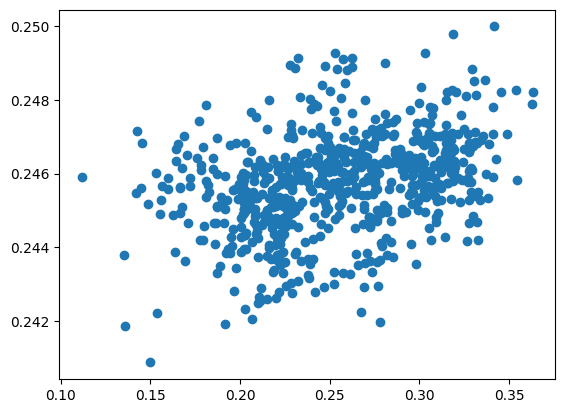

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(true_values, predicted_values)

As we noted before, the model predictions are not good; predicts nearly constant value. We can also arrive at the conclusion from the R<sup>2</sup> score

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

print("R2 score ", r2_score(true_values,predicted_values))
print("MAE ", mean_absolute_error(true_values,predicted_values))

R2 score  -0.00810753681900267
MAE  0.03976681162385798


The implementation of the MPNN model on QM9 is reported in [this](https://arxiv.org/abs/1704.01212) article.